In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from sklearn.linear_model import LinearRegression

from sympy.solvers import solve
from sympy import *

%matplotlib inline

# MA(q) processes

$$y_t = \alpha_0 \eta_t + \alpha_1 \eta_{t-1} + ... + \alpha_q \eta_{t-q}$$

$$ y_t = \left( \sum_{i=0}^g \alpha_i B^i\right)\eta_t $$

where:
* $\eta$ is a White Gaussian Noise
* $<\eta_t> = 0$
* $<\eta^2>=1$
* $B$ - backshift operator ($B^0 = 1$)



## a)
Find the orderpand fit the parameters: $\beta_i(i= 1,...,p)$, $\alpha_0$ using the 2-step linear regression method. In order to find $p$ and the best fit use the "AIC" and "BIC" criteria.
Use $m=5$to estimate the realized noise in 1-st step and remember about normalizing it such that the variance is  1, in 2-nd step use this data to fit regression of $y(t)$ against the (shifted) noise variables.

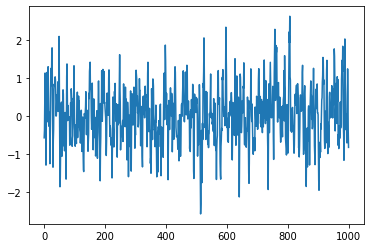

In [2]:
data = []

with open("MAdata.txt", "r") as f:
    for line in f:
        data.append(float(line))
        
data = np.array(data)
plt.plot(data)

### Two step regression: step 1

In [3]:
def dividing_data_into_subseries_II(data, k=2):
    X = []
    Y = []
    for i in range(len(data)-k):
        tmp = []
        for j in range(k):
            tmp.append(data[j+i])
        X.append(tmp)
        Y.append(data[k+i] )
    
    return np.array(X), np.array(Y)

In [4]:
X,Y = dividing_data_into_subseries_II(data, k=5) 

reg = LinearRegression(fit_intercept = False).fit(X, Y)
prediction = reg.predict(X)

print("fitted coefficients  beta_(t-4)...beta_(t-1): {:}".format(reg.coef_) )

eps = Y - reg.predict(X)
eps = eps/eps.std()

print("\nmean= {:2f}\t std = {:2f}".format( eps.mean(), eps.std()))

fitted coefficients  beta_(t-4)...beta_(t-1): [-0.11996622  0.36024784 -0.37833758 -0.08663265  0.80459043]

mean= 0.013197	 std = 1.000000


In [5]:
YY = np.vstack((Y,eps)).transpose()
np.hstack((YY, X))
df = pd.DataFrame(np.hstack((X,YY)), columns = ['y(t5)', 'y(t4)', 'y(t3)', 'y(t2)', 'y(t1)', 'y(t)', 'eps'])

df['eps+1'] = df['eps'].shift(1)
df['eps+2'] = df['eps'].shift(2)
df['eps+3'] = df['eps'].shift(3)
df['eps+4'] = df['eps'].shift(4)
df['eps+5'] = df['eps'].shift(5)

df.dropna(inplace = True)
df

,y(t5),y(t4),y(t3),y(t2),y(t1),y(t),eps,eps+1,eps+2,eps+3,eps+4,eps+5
5,-0.192600,-1.299081,-0.226935,0.065571,1.144725,0.265750,-0.563038,1.353333,0.103533,1.123592,-1.602866,-0.475611
6,-1.299081,-0.226935,0.065571,1.144725,0.265750,-0.153007,-0.614121,-0.563038,1.353333,0.103533,1.123592,-1.602866
7,-0.226935,0.065571,1.144725,0.265750,-0.153007,0.284510,1.575092,-0.614121,-0.563038,1.353333,0.103533,1.123592
8,0.065571,1.144725,0.265750,-0.153007,0.284510,1.295828,1.452625,1.575092,-0.614121,-0.563038,1.353333,0.103533
9,1.144725,0.265750,-0.153007,0.284510,1.295828,0.755126,-0.540861,1.452625,1.575092,-0.614121,-0.563038,1.353333
...,...,...,...,...,...,...,...,...,...,...,...,...
991,-0.363077,0.036522,0.048544,-0.697383,-0.713475,0.160522,1.231984,0.122370,-1.847775,0.172484,0.156206,-0.317439
992,0.036522,0.048544,-0.697383,-0.713475,0.160522,1.239079,1.494245,1.231984,0.122370,-1.847775,0.172484,0.156206
993,0.048544,-0.697383,-0.713475,0.160522,1.239079,0.618735,-0.730864,1.494245,1.231984,0.122370,-1.847775,0.172484
994,-0.697383,-0.713475,0.160522,1.239079,0.618735,-0.401085,-1.080186,-0.730864,1.494245,1.231984,0.122370,-1.847775


### Two step regression: step 2

In [6]:
def get_AIC_BIC(df, x_cols):
    
    k=len(x_cols)
    Y = np.array(df['y(t)'])
    X = np.array(df[x_cols])
    
    reg = LinearRegression(fit_intercept = False).fit(X, Y)
    prediction = reg.predict(X)
    N = len(X)
    
    alpha = np.sqrt(((Y-prediction)**2).mean())   
    AIC = N*np.log(((Y-prediction)**2).mean()) + 2*k   
    BIC = N*np.log(((Y-prediction)**2).mean()) + np.log(N)*k    
    
    print("\n\nk = {:}, alpha = {:}\t AIC = {:}\t BIC = {:}\n".format(k,alpha, AIC, BIC))
    print("intercept = {:}\t reg.coef_ = {:}".format(reg.intercept_, reg.coef_) )
    
    return [k, alpha, AIC, BIC]

In [7]:
tab = []

tab.append(get_AIC_BIC(df, ['eps+1'] ))
tab.append(get_AIC_BIC(df, ['eps+1', 'eps+2'] ))
tab.append(get_AIC_BIC(df, ['eps+1', 'eps+2', 'eps+3'] ))
tab.append(get_AIC_BIC(df, ['eps+1', 'eps+2', 'eps+3', 'eps+4'] ))
tab.append(get_AIC_BIC(df, ['eps+1', 'eps+2', 'eps+3', 'eps+4', 'eps+5'] ))



k = 1, alpha = 0.5983398034602126	 AIC = -1015.948170249943	 BIC = -1011.049455715613

intercept = 0.0	 reg.coef_ = [0.40763142]


k = 2, alpha = 0.5112762579620876	 AIC = -1325.6152114266736	 BIC = -1315.8177823580136

intercept = 0.0	 reg.coef_ = [0.41227231 0.31086954]


k = 3, alpha = 0.510873738399572	 AIC = -1325.1762226617864	 BIC = -1310.4800790587965

intercept = 0.0	 reg.coef_ = [ 0.41314462  0.3105654  -0.02029883]


k = 4, alpha = 0.5108607704161228	 AIC = -1323.2265342505132	 BIC = -1303.6316761131932

intercept = 0.0	 reg.coef_ = [ 0.41330546  0.31040558 -0.02024874  0.00364592]


k = 5, alpha = 0.5098490840077213	 AIC = -1325.1554923366602	 BIC = -1300.6619196650104

intercept = 0.0	 reg.coef_ = [ 0.41343387  0.3117848  -0.02167565  0.00412761  0.03220715]


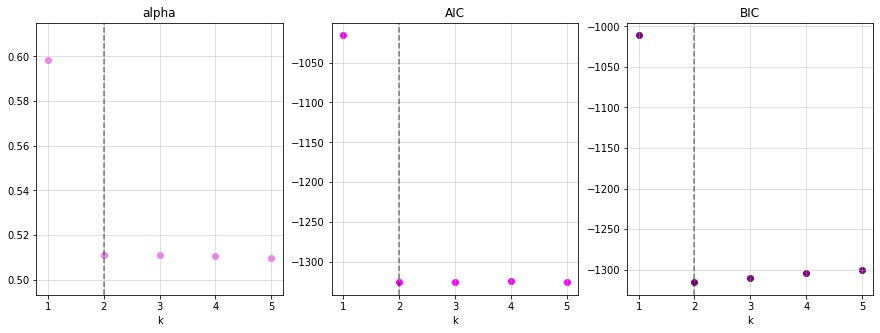

In [8]:
k_tab, alpha_tab, AIC_tab, BIC_tab = np.array(tab).transpose()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (15,5))
for ax in axs:
    ax.set_xlabel('k')
    ax.grid(True, alpha = 0.5)
    ax.axvline(x = 2, linestyle='dashed', color = 'black', alpha = 0.5)
    
axs[0].set_title('alpha')
axs[1].set_title('AIC')
axs[2].set_title('BIC')
axs[0].scatter(k_tab, alpha_tab, color = 'violet')
axs[1].scatter(k_tab, AIC_tab, color = 'fuchsia')
axs[2].scatter(k_tab, BIC_tab, color = 'purple')

According to the 2-step regression method, q=2 is the order of MA(q) process with the coefficients:
* $\beta_1 = 0.4112644$ (coefficient at eps+1)
* $\beta_2 = 0.3131448$ (coefficient at eps+2)
* $alpha_0 = 0.5112762$

In [9]:
q=2 
Y = np.array(df['y(t)'])
X = np.array(df[['eps+1','eps+2']])
    
reg = LinearRegression(fit_intercept = False).fit(X, Y)
prediction = reg.predict(X)
N = len(Y)

alpha_0 = np.sqrt(((Y-prediction )**2).mean())
AIC = N*np.log(((Y-prediction)**2).mean() )+ 2*q   
BIC = N*np.log(((Y-prediction)**2).mean()) + np.log(N)*q    
   
print("\n\nq = {:}, alpha = {:}\t AIC = {:}\t BIC = {:}\n".format(q,alpha_0, AIC, BIC))
print("reg.coef_ = {:}\tintercept = {:}".format(reg.coef_, reg.intercept_) )
    



q = 2, alpha = 0.5112762579620876	 AIC = -1325.6152114266736	 BIC = -1315.8177823580136

reg.coef_ = [0.41227231 0.31086954]	intercept = 0.0


# b) 
Compute  the  sample autocorrelation function (SACF), $\rho(t)$ and the sample partial autocorrelation function (SPACF),$\phi(t)$ and plot them for $t= 1,...10$. Based on the plot of SPACF check the orderp (on the plot include Gaussian N(0,(T−t)−1) bands for $95\%$ confidence level to check when SPACF becomes statistically zero).

In [10]:
def dividing_data_into_subseries(data, k=2, k_max=11):
    data_k = []
    for i in range(len(data)-k_max):
        tmp = [ ]
        for j in range(k):
            tmp.append(data[j+i])
        tmp.append(data[k+i])
        data_k.append(tmp)
    return np.array(data_k).T

In [11]:
def get_autocorrelation_coeff(data, delta):
    
    data_k = dividing_data_into_subseries(data, k=delta)  
    denominator = (data**2).mean()
    nominator = (data_k[0]*data_k[-1]).mean()
    
    return nominator/denominator
    

In [12]:
def get_autocorrelation(p,data):
    
    autocorrelation_tab = []

    for delta in range(1,p+1):
        autocorrelation = get_autocorrelation_coeff(data, delta)
        autocorrelation_tab.append(autocorrelation)
    
    return autocorrelation_tab

### sample autocorrelation function (SACF)

Δt = 1	 ρ(Δt)=0.639600
Δt = 2	 ρ(Δt)=0.294154
Δt = 3	 ρ(Δt)=-0.003510
Δt = 4	 ρ(Δt)=0.014596
Δt = 5	 ρ(Δt)=0.010283
Δt = 6	 ρ(Δt)=-0.027150
Δt = 7	 ρ(Δt)=-0.075388
Δt = 8	 ρ(Δt)=-0.090840
Δt = 9	 ρ(Δt)=-0.086528
Δt = 10	 ρ(Δt)=-0.062394


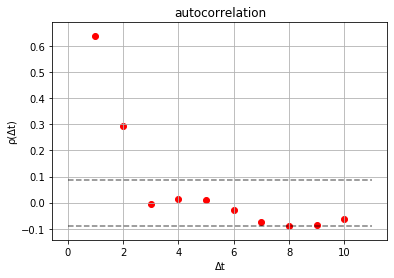

In [13]:
p=10
p_tab = list(range(1,p+1))
autocorrelation_tab = get_autocorrelation(p,data)

for delta_t, corr in zip(p_tab, autocorrelation_tab):
    print(u'\u0394t = {:}\t \u03C1(\u0394t)={:2f}'.format(delta_t,corr ))

N = 490
confidence_level = 1.96/np.sqrt(N)


plt.title('autocorrelation')
plt.scatter(p_tab, autocorrelation_tab, color ='red')  
plt.ylabel(u'\u03C1(\u0394t)')
plt.xlabel(u'\u0394t')
plt.grid()

plt.hlines(y = confidence_level, xmin=0, xmax = p+1, linestyles='dashed', color = 'black', alpha = 0.5)
plt.hlines(y = -confidence_level, xmin=0, xmax = p+1, linestyles='dashed', color = 'black', alpha = 0.5)


###  Partial autocorrelation function (PACF)

In [14]:
def get_partial_autocorrelation(p, data):
    
    autocorrelation_tab = get_autocorrelation(p,data)
    
    M = np.identity(p)*0.5
    for i in range(p):
        for j in range(i+1, p):
            M[i][j] = autocorrelation_tab[j-i-1]
    
    A = np.matrix(M.T + M)
    A_inv = np.linalg.inv(A) 
    
    psi_vec = np.array(np.dot(A_inv,autocorrelation_tab))[0]
    
    return psi_vec[-1]

Δt = 1	 Φ(Δt)=0.639600
Δt = 2	 Φ(Δt)=-0.194504
Δt = 3	 Φ(Δt)=-0.182638
Δt = 4	 Φ(Δt)=0.273179
Δt = 5	 Φ(Δt)=-0.125215
Δt = 6	 Φ(Δt)=-0.128887
Δt = 7	 Φ(Δt)=0.086820
Δt = 8	 Φ(Δt)=-0.060005
Δt = 9	 Φ(Δt)=-0.071853
Δt = 10	 Φ(Δt)=0.060464


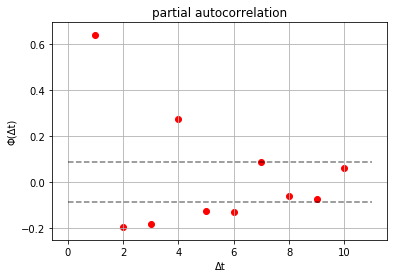

In [15]:
p=10
p_tab = list(range(1,p+1))
partial_corr_tab_tab = []

for k in range(1,p+1):
    partial_corr_tab_tab.append(get_partial_autocorrelation(k,data))


for delta_t, p_corr in zip(p_tab, partial_corr_tab_tab):
    print(u'\u0394t = {:}\t \u03A6(\u0394t)={:2f}'.format(delta_t, p_corr ))

    
plt.title('partial autocorrelation')
plt.scatter(p_tab, partial_corr_tab_tab, color ='red')  
plt.ylabel(u'\u03A6(\u0394t)')
plt.xlabel(u'\u0394t')
plt.grid()
plt.hlines(y = confidence_level, xmin=0, xmax = p+1, linestyles='dashed', color = 'black', alpha = 0.5)
plt.hlines(y = -confidence_level, xmin=0, xmax = p+1, linestyles='dashed', color = 'black', alpha = 0.5)

The autocorrelation drops abruptly to 0 (with confidence level $95\%$) after $q=2$, therefore we may assume that the order of MA(q) process is 2.

# c

For the order $q$ established in (b) fit the parameters: $\beta_i (i=1,...,q)$ and $\alpha_0$ using the Yule-Walkermethod (in the matrix form).

In [16]:
def dividing_data_into_subseries(data, k=2):
    data_k = []
    for i in range(len(data)-k):
        tmp = [ ]
        for j in range(k):
            tmp.append(data[j+i])
        tmp.append(data[k+i])
        data_k.append(tmp)  
    return np.array(data_k).T

In [17]:
data_1 = dividing_data_into_subseries(data, k=1)  
data_2 = dividing_data_into_subseries(data, k=2)  
data_3 = dividing_data_into_subseries(data, k=3)  


We are looking for the autocorrelation function $ACF \equiv \rho\Delta t$

$$ <y_ty_{\Delta t}> = <y_t^2>\rho_{\Delta t}$$

$$ y_t = \sum_{i=0}^g\alpha_i\eta_{t-i}$$

$$ y_{t-\Delta t} = \sum_{i=0}^g\alpha_j\eta_{t-\Delta t -j}$$
$$ <y_ty_{t-\Delta t}> =  \sum_{i=0}^g\sum_{j=0}^g<\eta_{t-i}\eta_{t-\Delta t -h}> = \sum_{i=\Delta t}^g \alpha_i \alpha_{i-\Delta t} $$

In [18]:
cov0 = (data**2).mean()
cov1 = (data_1[0]*data_1[-1]).mean()
cov2 = (data_2[0]*data_2[-1]).mean()
cov3 = (data_3[0]*data_3[-1]).mean()

print("cov0 = {:2f} \t cov1 = {:2f}\t cov2 = {:2f} \tcov3 = {:2f} ".format(cov0, cov1,cov2,cov3))

cov0 = 0.524192 	 cov1 = 0.333107	 cov2 = 0.150836 	cov3 = -0.003968 


### Yule Walker Equations:


* MA(1):
$$ <y_ty_t>=\alpha_0^2+\alpha_1^2 $$
$$ <y_ty_{t-1}>=\alpha_0\cdot\alpha_1 $$

* MA(2):
$$ <y_ty_t>=\alpha_0^2+\alpha_1^2 +\alpha_2^2 $$
$$ <y_ty_{t-1}>=\alpha_0\alpha_1 +\alpha_1\alpha_2 $$
$$ <y_ty_{t-2}>=\alpha_0\alpha_2 $$

In [19]:
alpha0, alpha1, alpha2 = symbols('alpha0 alpha1 alpha2', real=True)
x = symbols('x')

In [20]:
## q=1

f1 = cov0-alpha0**2-alpha1**2
f2 = cov1-alpha0*alpha1

sol_q1 = solve( [f1,f2], set = True)
sol_q1 = sol_q1[1]
sol_q1

set()

In [21]:
## q=2

f1=cov0-alpha0**2-alpha1**2-alpha2**2
f2=cov1-alpha0*alpha1-alpha1*alpha2
f3=cov2-alpha0*alpha2

sol_q2 = solve( [f1,f2,f3], set = True)
sol_q2 = sol_q2[1]
sol_q2

{(-0.521048424658716, -0.410972423453576, -0.289485433038988),
 (-0.289485433038988, -0.410972423453576, -0.521048424658716),
 (0.289485433038988, 0.410972423453576, 0.521048424658716),
 (0.521048424658716, 0.410972423453576, 0.289485433038988)}

### Invertibility condition: checking the roots of the polynomial:
$$\sum a_iz^i = 0$$

If we take only $a_i$'s such that the roots $|z|<1$, we are left with:


In [22]:
X = [1,x,x**2]

for coeffs in list(sol_q2):   
    roots = solve(sum(list(map(lambda x,y: x*y, X, coeffs))))
    print("\ncoeffs:\t", coeffs)
    print("roots:\t", roots)


coeffs:	 (0.521048424658716, 0.410972423453576, 0.289485433038988)
roots:	 [-0.709832648812809 - 1.13844192863999*I, -0.709832648812809 + 1.13844192863999*I]

coeffs:	 (-0.521048424658716, -0.410972423453576, -0.289485433038988)
roots:	 [-0.709832648812809 - 1.13844192863999*I, -0.709832648812809 + 1.13844192863999*I]

coeffs:	 (0.289485433038988, 0.410972423453576, 0.521048424658716)
roots:	 [-0.394370661155689 - 0.632498514735841*I, -0.394370661155689 + 0.632498514735841*I]

coeffs:	 (-0.289485433038988, -0.410972423453576, -0.521048424658716)
roots:	 [-0.394370661155689 - 0.632498514735841*I, -0.394370661155689 + 0.632498514735841*I]


for $q = 2$ we have two possible sets of coefficients $alpha_i$:

* $\alpha_0 = 0.52105$,  $\alpha_1 = 0.41097$, $\alpha_2 = 0.28949$

* $\alpha_0 =-0.52105$  $\alpha_1 = -0.41097$, $\alpha_2 = -0.28949$
     

# d) 

Using the data and the fit of point  (a)  and/or  (c)  compute  the empirical noise 

$$ \hat{\eta}(t) = \frac{y_t - \hat{y_t}}{\alpha_0}$$ and check  if  it  has  standard  Gaussian N(0,1)  distribution  (use  e.g.Kolmogorov-Smirnov test).

In [23]:
## Based on results in a:

coeff_a = np.array([ 0.41126442, 0.31314482])  ##  a1, a2
alpha_0a = 0.5113506601881491

## Based on results in c:
coeff_c = np.array([0.410972423453576, 0.289485433038988]) ## a1, a2
alpha_0c = 0.521048424658716

In [24]:
df.drop(['y(t5)', 'y(t4)','y(t3)', 'eps+3', 'eps+4', 'eps+5'], inplace = True, axis = 1)
df.head()

,y(t2),y(t1),y(t),eps,eps+1,eps+2
5,0.065571,1.144725,0.265750,-0.563038,1.353333,0.103533
6,1.144725,0.265750,-0.153007,-0.614121,-0.563038,1.353333
7,0.265750,-0.153007,0.284510,1.575092,-0.614121,-0.563038
8,-0.153007,0.284510,1.295828,1.452625,1.575092,-0.614121
9,0.284510,1.295828,0.755126,-0.540861,1.452625,1.575092


In [25]:
q=2 
Y = np.array(df['y(t)'])
X = np.array(df[['eps+1','eps+2']])
N = len(Y)

reg = LinearRegression(fit_intercept = False).fit(X, Y)
df['prediction'] = reg.predict(X)

alpha_0 = np.sqrt(((Y-df['prediction'] )**2).mean())
df['empirical_noise'] = (Y - prediction)/alpha_0

print("reg.coef_ = {:}\t alpha_0 = {:}".format(reg.coef_, alpha_0) )

reg.coef_ = [0.41227231 0.31086954]	 alpha_0 = 0.5112762579620874


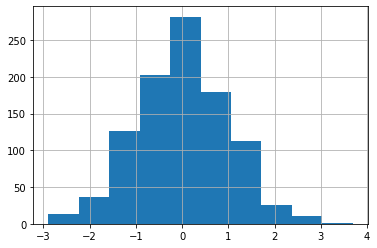

In [26]:
df['empirical_noise'].hist()

In [27]:
df['empirical_noise'].std()

1.0004284202360652

In [28]:
from scipy.stats import norm, kstest

D_N, p_value = kstest(df['empirical_noise'], 'norm', args=(0,1))

print("data: test statistic: D_N = {:},  p-value = {:}".format(D_N, p_value) )

data: test statistic: D_N = 0.025872930770524993,  p-value = 0.520767196660961


# e) 

Using the fit of point (a) and/or (c) simulate $N=100$  future(forecast) paths for $t=T+1,T+2,...,T+10$. Using the generated forecast paths estimate  the  mean  value $<y(t)>$ and the standard deviation $\sigma(y(t))$ of $y(t)$ for each future $t=T+ 1,T+ 2,T+ 10$ and plot them as the continuation of the sample data series (plot of mean with error bars of standard deviation).


We may predict only 2 next steps for MA(2) process

In [31]:
def data_generator(alpha1, alpha2, alpha_0, past_data, T=2):
        
    for i in range(len(past_data), T + len(past_data)):
        noise = np.random.normal(0,1)
        new = alpha_0*noise + alpha1*past_data[i-1] + alpha2*past_data[i-2] 
        past_data= np.append(past_data,new)

    return past_data

In [32]:
alpha1, alpha2 = [ 0.41126442, 0.31314482]
alpha_0 = 0.5113506601881491

past_data = data[-2:]
n = 100
data_gen = []

for i in range(n):
    data_gen.append(data_generator(alpha1, alpha2, alpha_0, past_data))

In [34]:
cols=[ 't-1', 't', 't+1', 't+2']

df_gen = pd.DataFrame(data_gen, columns = cols)
df_gen

,t-1,t,t+1,t+2
0,-0.401085,-0.831914,0.043877,-0.374000
1,-0.401085,-0.831914,-1.344821,-1.238094
2,-0.401085,-0.831914,-0.257514,-0.943468
3,-0.401085,-0.831914,-0.456999,-1.223775
4,-0.401085,-0.831914,-0.704910,-0.630838
...,...,...,...,...
95,-0.401085,-0.831914,0.018417,0.314068
96,-0.401085,-0.831914,0.190134,0.092740
97,-0.401085,-0.831914,-0.861085,-0.987868
98,-0.401085,-0.831914,-0.380093,-0.194630


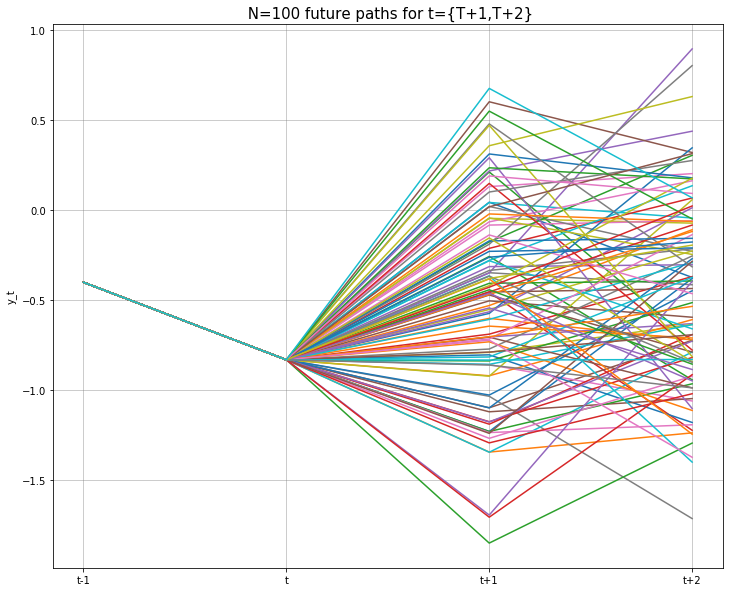

In [36]:
fig, ax = plt.subplots(figsize = (12,10))

ax.set_ylabel('y_t')
ax.set_title(' N=100 future paths for t={T+1,T+2}', fontsize = 15)
ax.grid(color = 'gray', alpha = 0.5)

for i in range(n):
    ax.plot(df_gen.loc[i])
